In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from nilearn import datasets
from mne_bids import BIDSPath
from nilearn.plotting import plot_markers
from utils import (
    calculate_pvalues,
    generate_null_dist,
    get_coord_atlas_labels,
    get_sub_coords,
)
from statsmodels.stats.multitest import multipletests

plt.style.use("figures.mplstyle")

In [40]:
models = ['spectral', 'whisper.medium', 'syntactic', 'en.core.web.lg', 'gpt2.xl.l24']
models = ['spectral', 'phonetic', 'syntactic', 'en.core.web.lg', 'gpt2.xl.l24']

In [41]:
model_results = []

for modelname in models:
    result_path = BIDSPath(
        root="../results",
        datatype="encoding",
        description=modelname,
        extension=".h5",
        check=False,
    )
    result_files = result_path.match()
    assert len(result_files) > 0

    sub_scores = []
    for result_path in result_files:
        result_path.update(description=modelname)
        with h5py.File(result_path, "r") as f:
            scores = f['scores'][...]
            lags = f['lags'][...]

            sub_scores.append(scores)

    sub_scores = np.vstack([s.mean(0) for s in sub_scores])
    print(modelname, sub_scores.shape, lags.shape)
    model_results.append(sub_scores)

spectral (1268, 128) (129,)
phonetic (1268, 128) (129,)
syntactic (1268, 128) (129,)
en.core.web.lg (1268, 128) (129,)
gpt2.xl.l24 (1268, 128) (129,)


In [42]:
lags = np.arange(-512 * 2, 512 * 2, 16)
lags.shape

(128,)

In [43]:
coords = get_sub_coords()
coords.shape

(1268, 3)

## atlas and coords

In [44]:
atlas = datasets.fetch_atlas_destrieux_2009()
indices = atlas['labels'].index
names = atlas['labels'].name
atlas_labels = {idx: name for idx, name in zip(indices, names)}

# atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=1, yeo_networks=17)
# atlas_labels = ['background'] + [l.decode() for l in atlas['labels']]

# atlas = fetch_atlas_glasser_2016()
# atlas_labels = atlas['labels'].to_dict()['label']

original_elec_labels = get_coord_atlas_labels(coords, atlas['maps'], atlas_labels)
elec_labels = [label.split()[1] for label in original_elec_labels]  # for destrieux

# elec_labels = [label.split("_")[1] for label in elec_labels]  # for glasser
# elec_labels = [label.split("_", 2)[-1].split("_")[1] for label in elec_labels]  # for schaefer
# elec_labels = [label.split("_", 2)[-1].split("_")[0] for label in elec_labels]  # for kong networks
# elec_labels = [label.split("_", 2)[-1] for label in elec_labels]  # for schaefer, just remove network and hemi

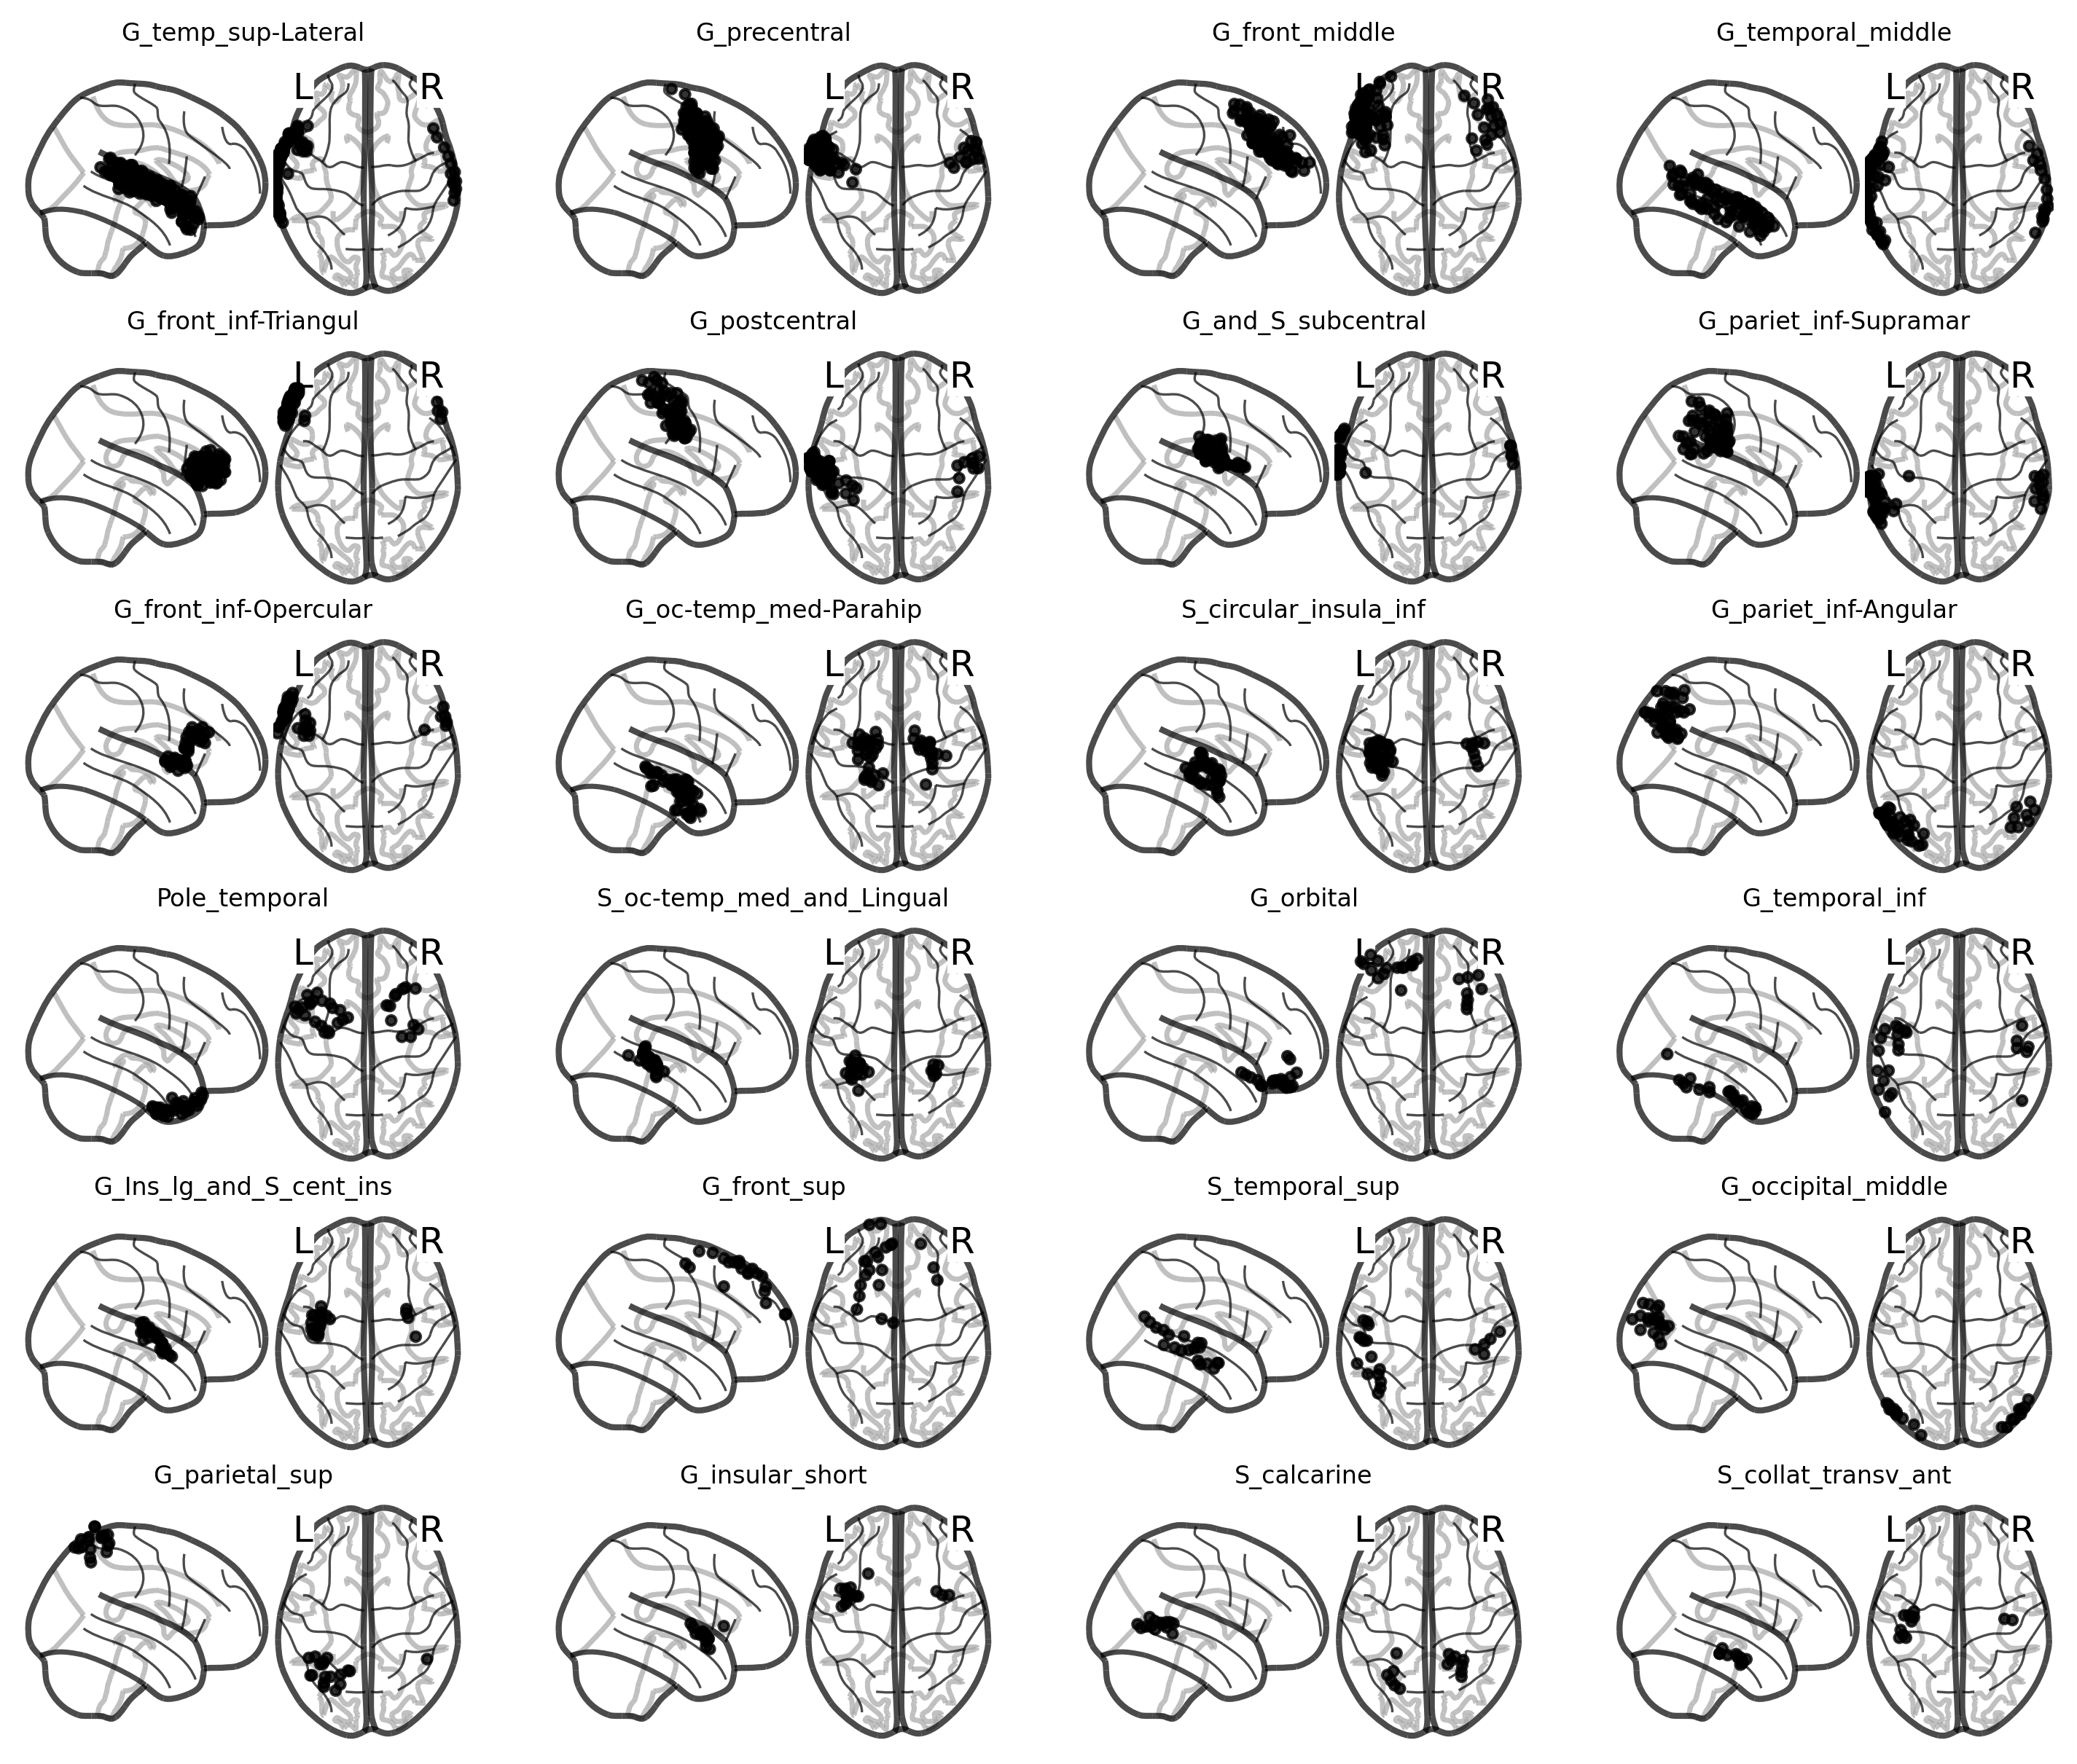

In [45]:
counter = Counter(elec_labels)
top_rois = counter.most_common(24)

fig, axes = plt.subplots(6, 4, sharex=True, sharey=True, dpi=300, figsize=(12, 10))

for (roi, count), ax in zip(top_rois, axes.ravel()):

    roi_mask = np.array([roi in label for label in elec_labels])
    roi_coords = coords[roi_mask]
    scores = np.ones(len(roi_coords))

    plot_markers(scores, coords[roi_mask],
                node_size=10, display_mode='xz',
                alpha=0.8, colorbar=False,
                node_cmap='Grays', node_vmin=0, node_vmax=1,
                figure=fig, axes=ax)

    ax.set_title(roi, fontsize=8)
fig.show()

# unthresholded results

0.05 0.26801425


0.05 0.16657795
0.05 0.1857407
0.05 0.20561747
0.05 0.26979268


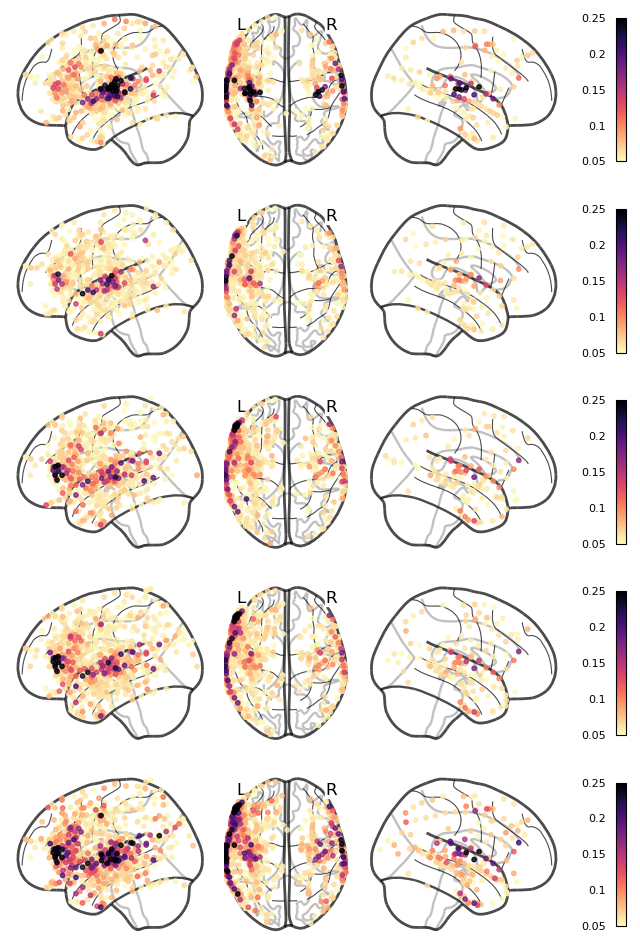

In [46]:
fig, axes = plt.subplots(5, 1, figsize=(8, 12), dpi=100)

for modelname, sub_scores, ax in zip(models, model_results, axes):
    scores = sub_scores.max(-1)

    vmin = .05
    vmax = np.quantile(scores, .99)
    print(vmin, vmax)
    vmax = 0.25

    order = scores.argsort()
    plot_markers(scores[order], coords[order],
                node_size=10, display_mode='lzr',
                node_cmap='magma_r', colorbar=True,
                alpha=0.8, 
                node_threshold=vmin,
                # title=modelname,
                node_vmin=vmin, node_vmax=vmax,
                figure=fig, axes=ax)

fig.savefig("../figures/figure3/model-brainmaps-nothresh.svg")
fig.show()

# sig thresholded

In [47]:
null_dist = generate_null_dist(seed=0)
null_dist.shape

(10000,)

In [48]:
model_sigmasks = []
for modelname, sub_scores in zip(models, model_results):
    scores = sub_scores.max(-1)

    p_values = calculate_pvalues(scores.reshape(-1, 1), null_dist, alternative='greater')
    fdr_out = multipletests(p_values, alpha=.01, method='fdr_bh')
    sigmask = fdr_out[0]
    print(modelname, sigmask.sum())
    model_sigmasks.append(sigmask)

common_sigmask = np.stack(model_sigmasks).all(0)
print("common", common_sigmask.sum())

spectral 510
phonetic 299
syntactic 580
en.core.web.lg 752
gpt2.xl.l24 874
common 142


In [49]:
# colors = [np.full(3, i) for i in [0.8, 0.6, 0.4, 0.2, 0.0]]
colors = plt.get_cmap('tab20')(np.arange(5))
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.73333333, 0.47058824, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ]])

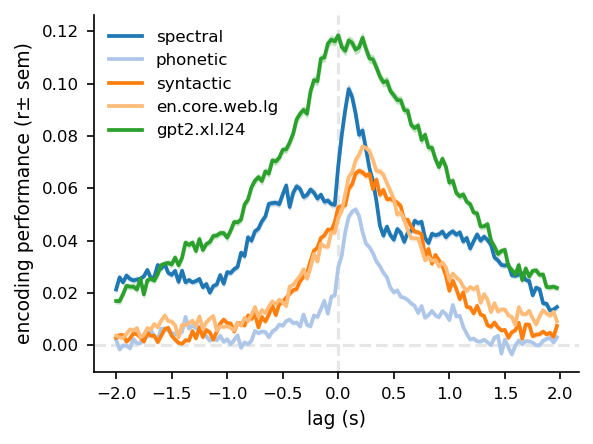

In [50]:
fig, ax = plt.subplots(figsize=(4, 4 / (4/3)), layout='tight')

ax.axvline(0, c=(.9, .9, .9), ls="--")
ax.axhline(0, c=(.9, .9, .9), ls="--")

for modelname, sub_scores, color in zip(models, model_results, colors):
    mean = sub_scores[common_sigmask].mean(0)
    err = sub_scores.std(0) / np.sqrt(sub_scores.shape[0])
    ax.fill_between(lags / 512, mean - err, mean + err, alpha=0.2, color=color)
    ax.plot(lags / 512, mean, color=color, label=modelname, lw=1.8)

ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r± sem)")
ax.legend(frameon=False, loc='best')

fig.savefig("../figures/figure3/models-lags.svg")
fig.show()

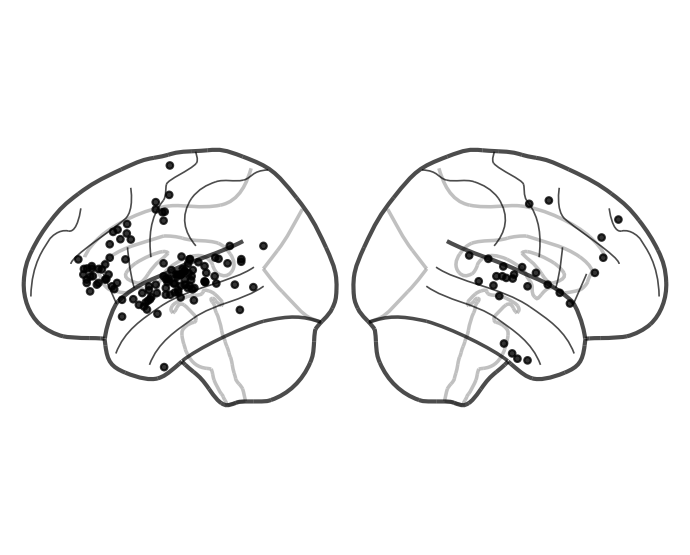

In [51]:
sig_coords = coords[common_sigmask]
fig = plot_markers(np.ones(len(sig_coords)), sig_coords,
            node_size=10, display_mode='lr',
            alpha=0.8, colorbar=False,
            node_cmap='Grays', node_vmin=0, node_vmax=1)
fig.savefig("../figures/figure3/brainmap-common-sig.svg")
fig

## per ROI

In [52]:
counter = Counter(np.array(elec_labels)[common_sigmask].tolist())
sig_rois = counter.keys()
len(counter), counter

(21,
 Counter({'G_temp_sup-Lateral': 45,
          'G_front_inf-Triangul': 22,
          'G_precentral': 11,
          'G_and_S_subcentral': 9,
          'G_front_inf-Opercular': 7,
          'G_front_middle': 7,
          'G_Ins_lg_and_S_cent_ins': 6,
          'G_temp_sup-G_T_transv': 6,
          'S_circular_insula_inf': 6,
          'G_temporal_middle': 5,
          'G_temporal_inf': 3,
          'Pole_temporal': 2,
          'S_temporal_sup': 2,
          'Lat_Fis-post': 2,
          'G_pariet_inf-Supramar': 2,
          'S_temporal_transverse': 2,
          'G_front_inf-Orbital': 1,
          'G_temp_sup-Plan_tempo': 1,
          'S_precentral-sup-part': 1,
          'G_temp_sup-Plan_polar': 1,
          'G_pariet_inf-Angular': 1}))

In [53]:
ROIs = {
    'EAC': ['G_and_S_subcentral',  'G_temp_sup-G_T_transv', 'S_circular_insula_inf', 'G_Ins_lg_and_S_cent_ins', 'S_temporal_transverse', 'Lat_Fis-post', 'S_temporal_sup'],
    'STG': ['G_temp_sup-Lateral'],
    'IFG': ['G_front_inf-Triangul', 'G_front_inf-Opercular', 'G_front_inf-Orbital'],
    'SM': ['G_precentral'],
    'MFG': ['G_front_middle'],
    'TP': ['Pole_temporal', 'G_temporal_inf'],
    'SMG': ['G_pariet_inf-Supramar', 'G_temp_sup-Plan_tempo', 'G_pariet_inf-Angular'],
    'MTG': ['G_temporal_middle', 'G_oc-temp_med-Parahip']
}

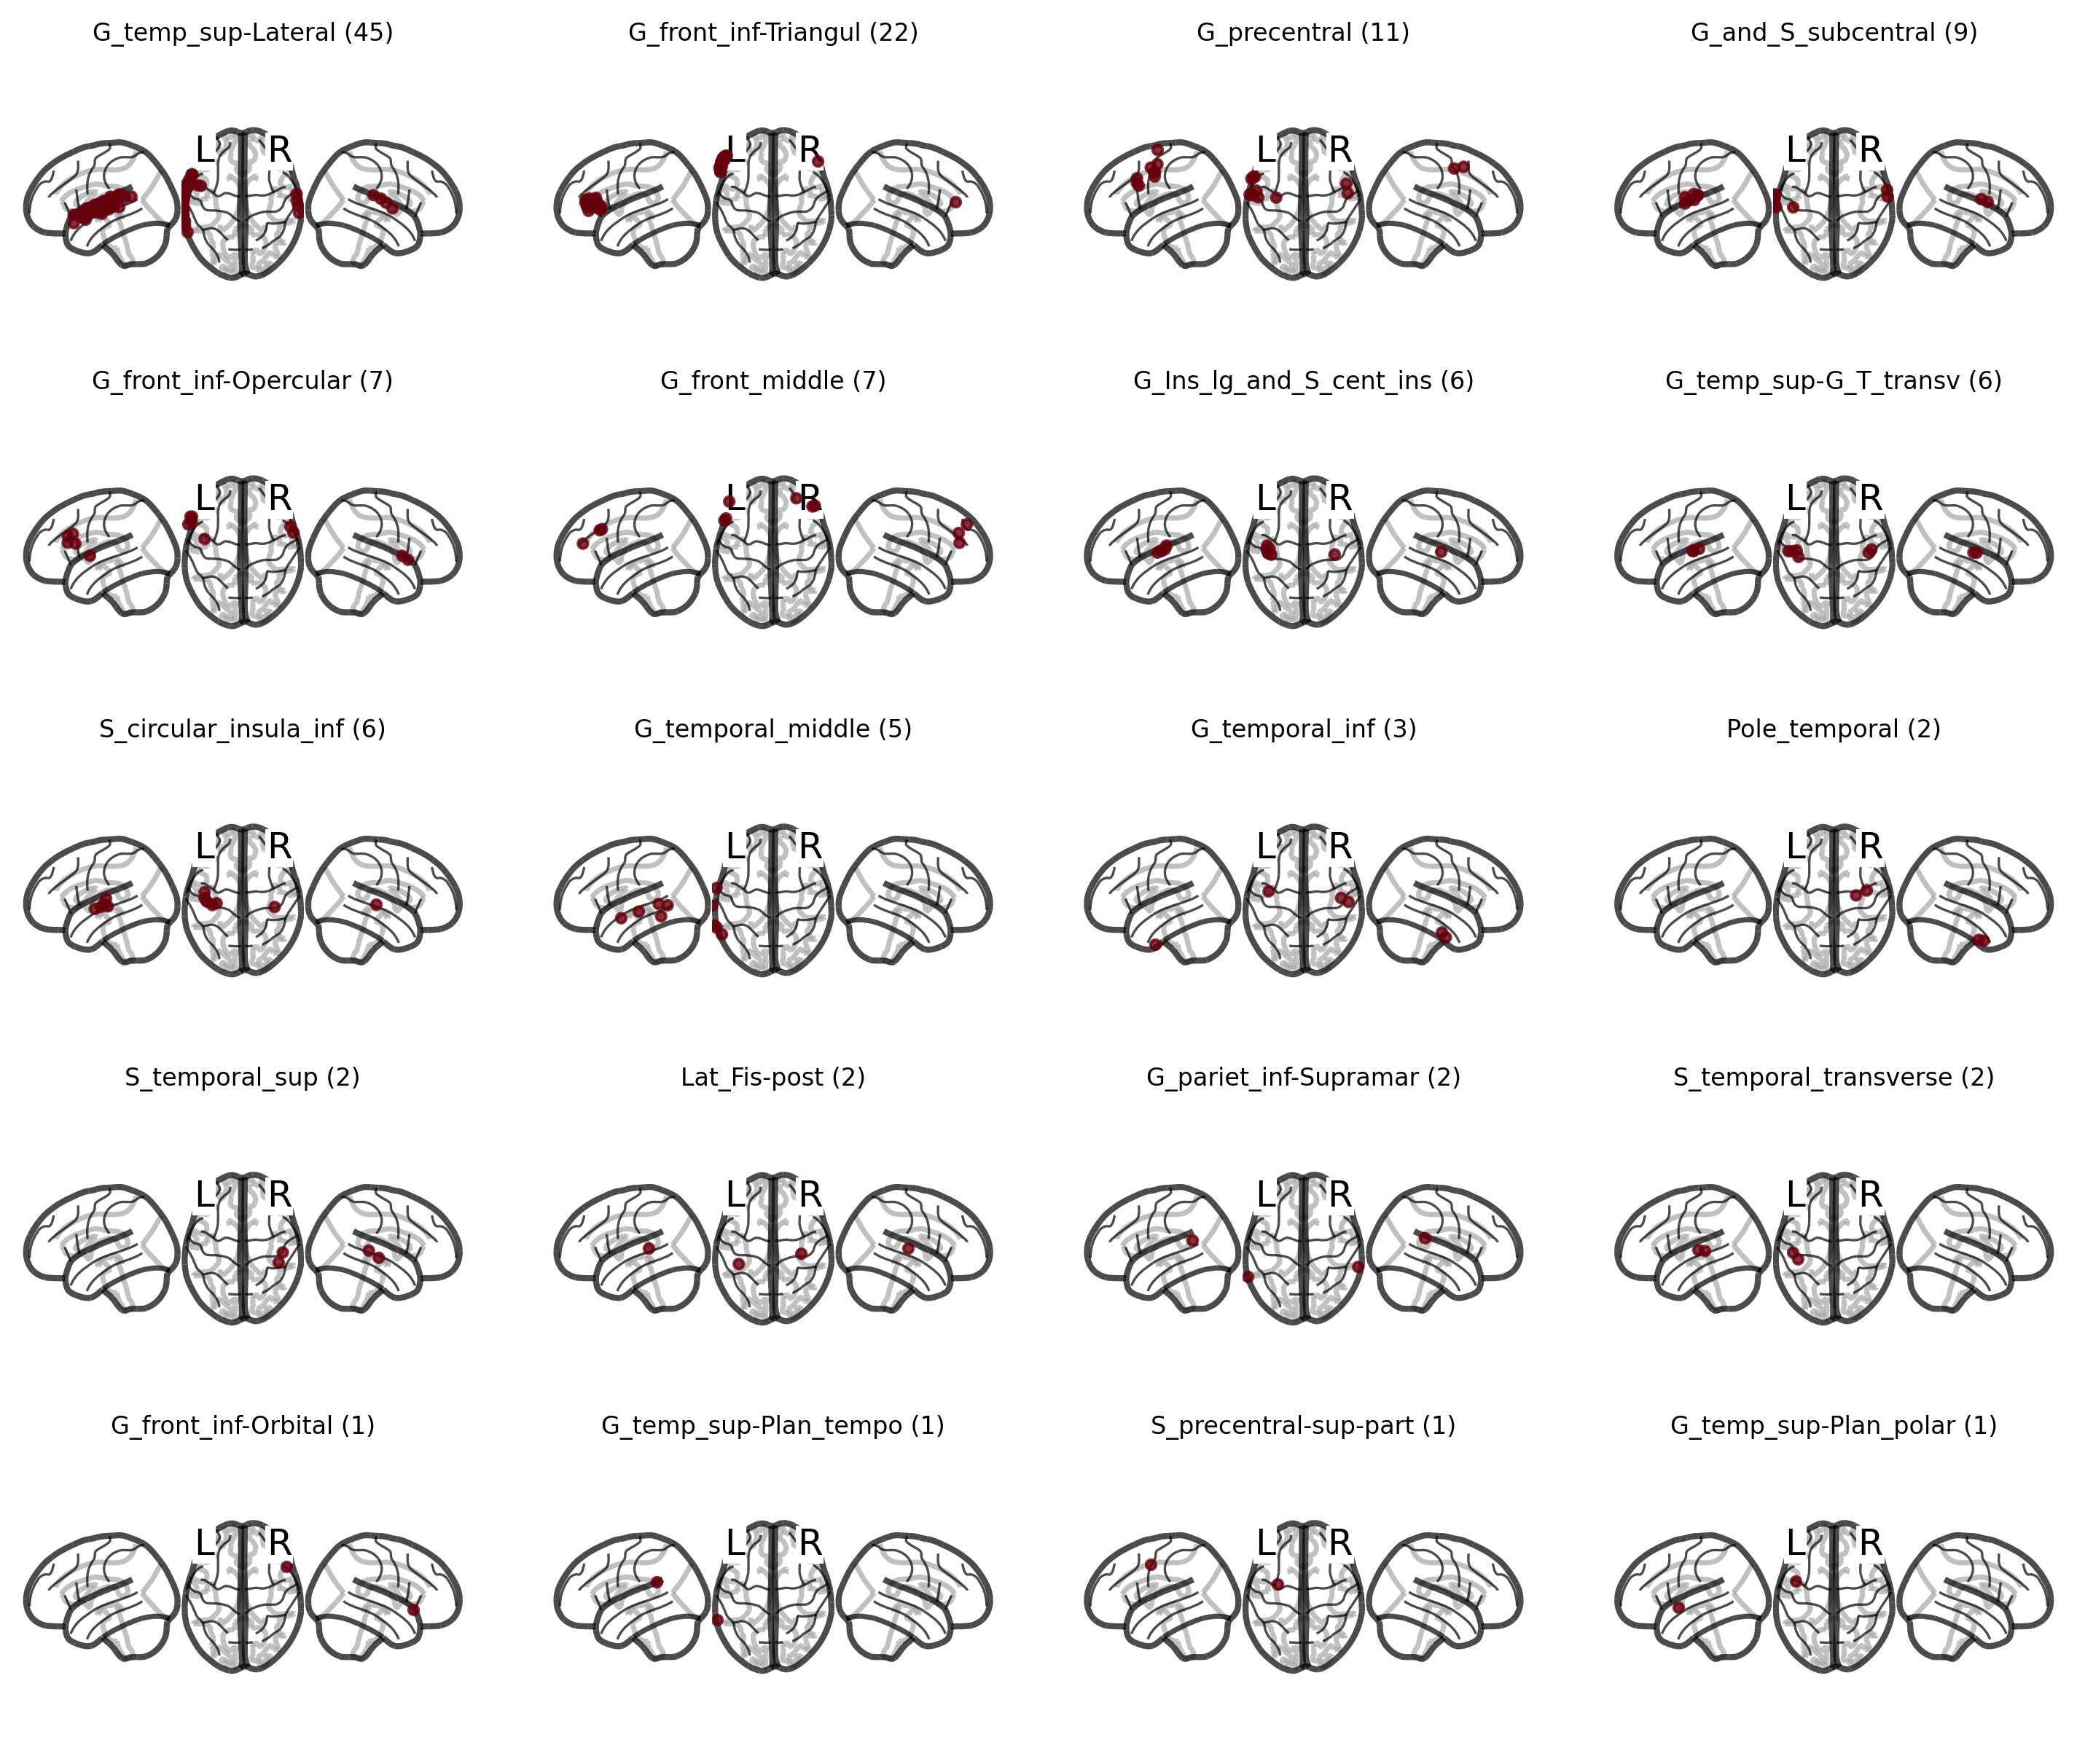

In [54]:
fig, axes = plt.subplots(5, 4, sharex=True, sharey=True, dpi=300, figsize=(12, 10))

for (roi, count), ax in zip(counter.most_common(20), axes.ravel()):

    roi_mask = np.array([roi == label for label in elec_labels])
    roi_mask &= common_sigmask
    roi_coords = coords[roi_mask]
    scores = np.ones(len(roi_coords))

    plot_markers(scores, coords[roi_mask],
                node_size=10, display_mode='lzr',
                alpha=0.8, colorbar=False,
                node_cmap='Reds', node_vmin=0, node_vmax=1,
                figure=fig, axes=ax)

    ax.set_title(f"{roi} ({count})", fontsize=8)
fig.show()

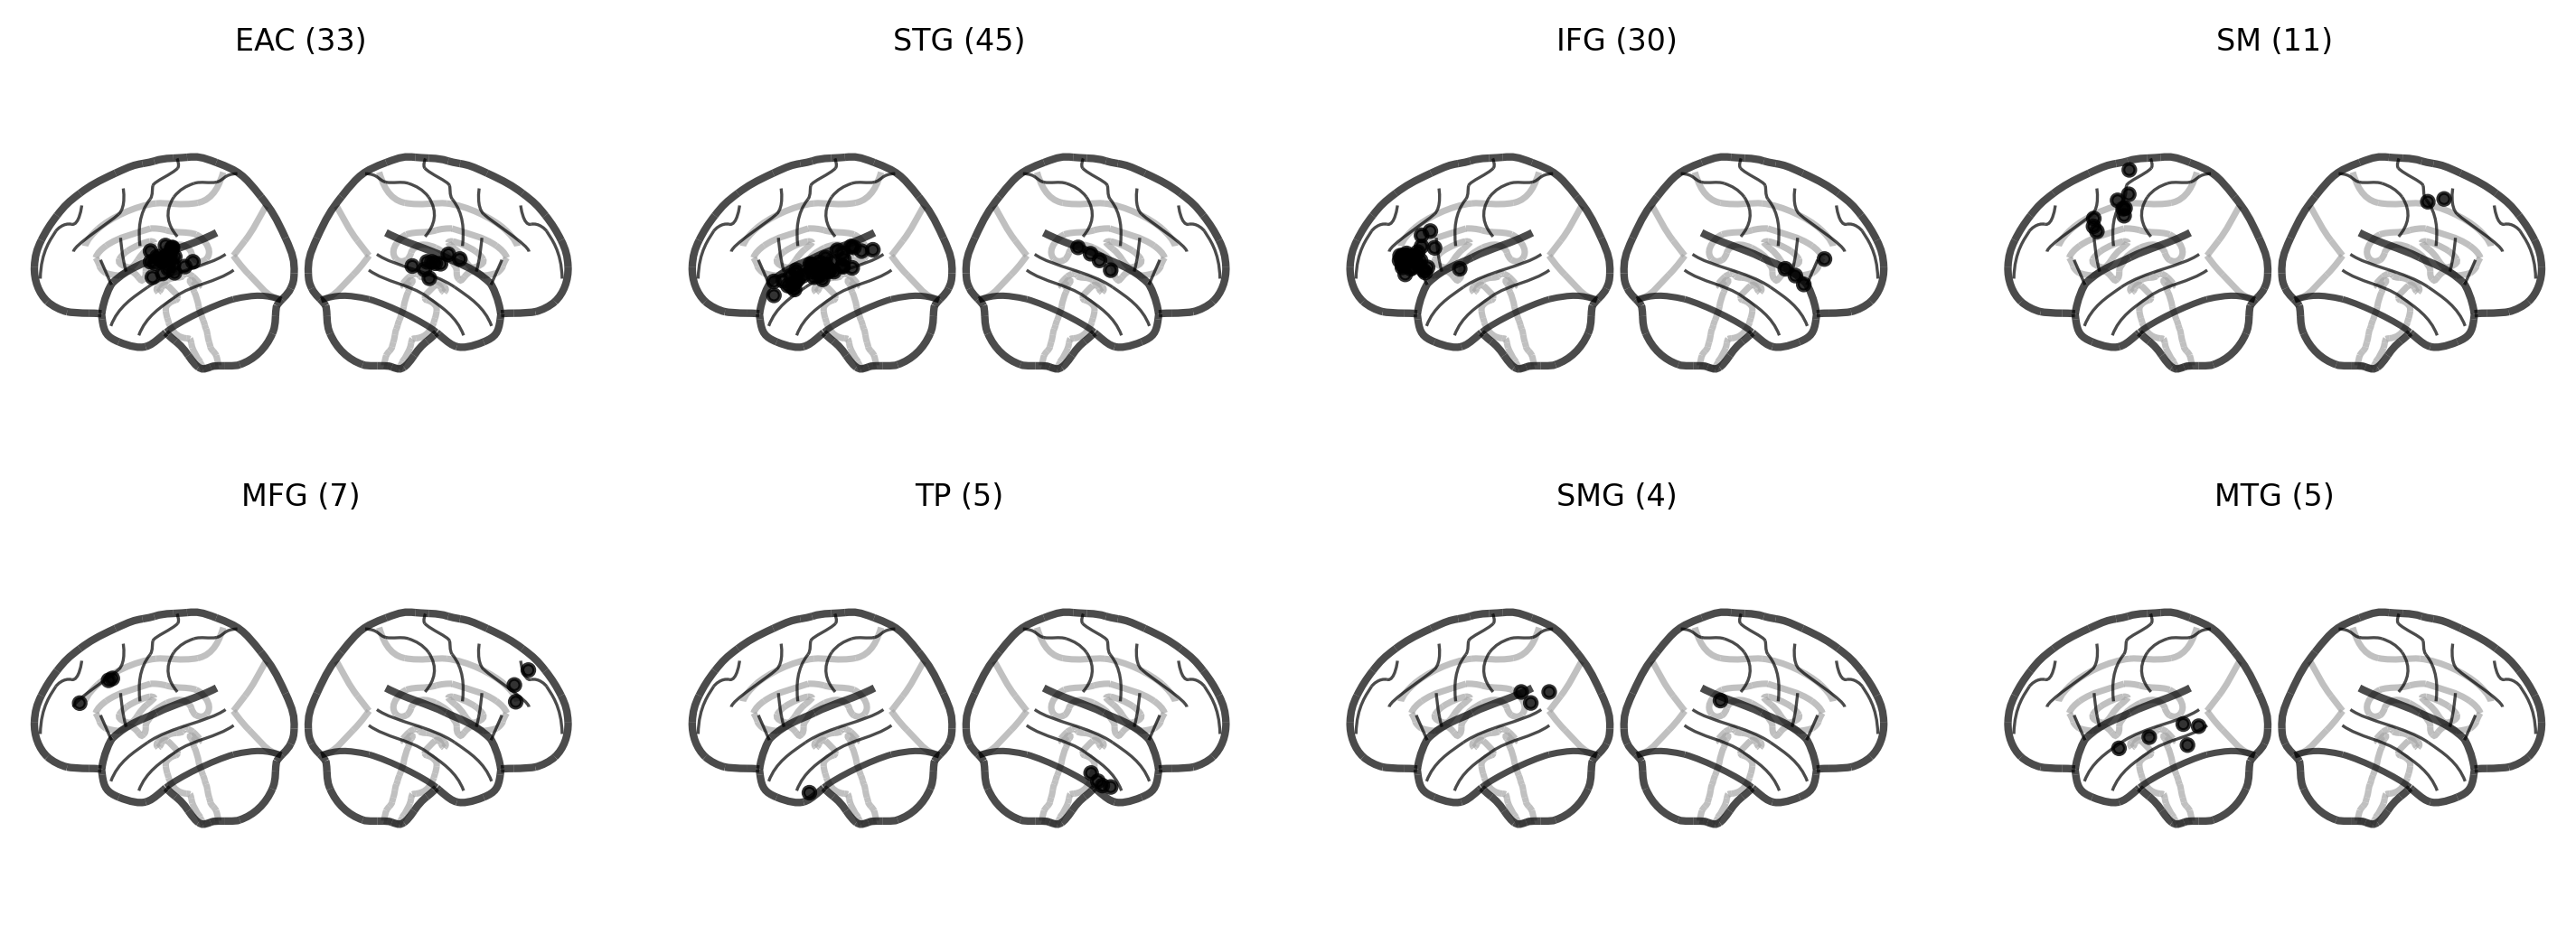

In [55]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, dpi=300, figsize=(12, 4))

for (roi, roi_labels), ax in zip(ROIs.items(), axes.ravel()):

    roi_mask = np.isin(elec_labels, roi_labels)
    roi_mask &= common_sigmask
    roi_coords = coords[roi_mask]
    count = roi_mask.sum()
    scores = np.ones(len(roi_coords))

    plot_markers(scores, coords[roi_mask],
                node_size=10, display_mode='lr',
                alpha=0.8, colorbar=False,
                node_cmap='Grays', node_vmin=0, node_vmax=1,
                figure=fig, axes=ax)

    ax.set_title(f"{roi} ({count})", fontsize=8)

fig.savefig("../figures/figure3/brain-schematic-rois.svg")
fig.show()

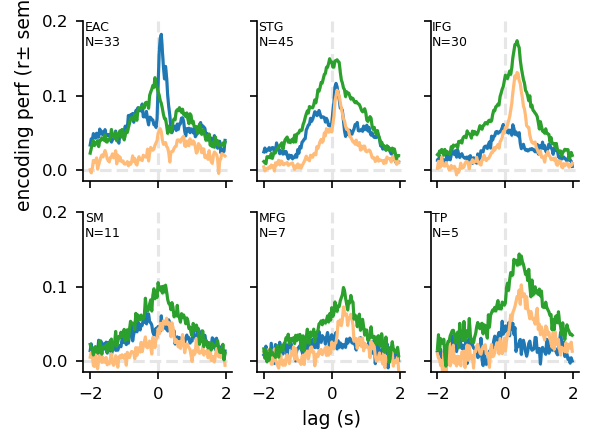

In [56]:
skip_models = ['phonetic', 'syntactic']
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(4, 4 / (4/ 3)), layout='tight')

for roi, ax in zip(ROIs, axes.ravel()):

    roi_mask = np.isin(elec_labels, ROIs[roi])
    roi_mask &= common_sigmask
    count = roi_mask.sum()

    ax.axvline(0, c=(.9, .9, .9), ls="--")
    ax.axhline(0, c=(.9, .9, .9), ls="--")
    # ax.set_title(f'{roi} ({count})', fontsize=6)

    ax.text(.01, 1, f'{roi}\nN={count}', transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            fontsize=6)

    for modelname, sub_scores, color in zip(models, model_results, colors):
        if modelname in skip_models: continue
        mean = sub_scores[roi_mask].mean(0)
        err = sub_scores.std(0) / np.sqrt(sub_scores.shape[0])
        ax.fill_between(lags/512, mean - err, mean + err, alpha=0.2, color=color)
        ax.plot(lags/512, mean, label=modelname, color=color)
    
    ax.set_ylim(ax.get_ylim()[0], 0.2)

axes[1, 1].set_xlabel("lag (s)")
axes[0, 0].set_ylabel("encoding perf (r± sem)")

fig.savefig("../figures/figure3/lags-rois.svg")
fig.show()